In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow import keras

TensorFlow version: 2.9.1


In [2]:
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import csv
import pickle
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from datetime import datetime
import numpy as np

## Loading a dataset

## Split into train data and test data as dataset
- データセットとして使用するデータを取得する。
- trainデータとtestデータに分割する。（例えば80%をtrainデータに、20%をtestデータに、など。）
- 書き方はデータセットとして使用するデータの type による。もし、numpy の形で持っているならhttps://www.tensorflow.org/tutorials/load_data/numpy?hl=ja が参考になります。

In [52]:
x_path = '../../data/npy/x_l3_1.npy'
x_data = np.load(x_path)

y_path = '../../data/npy/y_l3_1.npy'
y_data = np.load(y_path, allow_pickle=True)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)


print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

print(len(x_train), 'train examples')
print(len(x_test), 'test examples')
print(len(y_train), 'train examples')


(40, 1728)
(11, 1728)
(40,)
(11,)
40 train examples
11 test examples
40 train examples


## Set my model
- input_shape は入力データのサイズ。
- モデルの定義方法は調べればたくさん出てきますが、例えばここ： https://sinyblog.com/deaplearning/keras_how_to/ 
- 最後の層の出力は、期待する出力データのサイズ
- [model](https://github.com/si-tm/docs-l10n/blob/master/site/ja/tutorials/quickstart/beginner.py)

In [53]:
def build_model():
    
    model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(x_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'), # units=128 : 出力空間の次元数
    tf.keras.layers.Dropout(0.2), # 入力にドロップアウトを適用する rate=0.2 : 入力ユニットをドロップする割合
    tf.keras.layers.Dense(1) 
    ])

    optimizer = tf.keras.optimizers.Adam() # optimizers も Adam 以外に色々種類があります。調べてみてください！

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse']) # loss 関数に何を採用するかはどんな問題を解きたいのかによります。
                                        #ここでは MSE を採用していますが、他にも色々な選択肢があります。調べてみてください！
    return model

In [54]:
model = build_model()

In [55]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 1728)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               221312    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 221,441
Trainable params: 221,441
Non-trainable params: 0
_________________________________________________________________


In [56]:
example_batch = x_train[:10]
print(example_batch.shape)
example_result = model.predict(example_batch)
# example_result

(10, 1728)
1/1 [==============================] - 0s 123ms/step


In [57]:
print(example_result)

[[-0.0059257 ]
 [-0.05156914]
 [-0.05156914]
 [ 0.02428763]
 [ 0.02428763]
 [-0.05156914]
 [-0.03006675]
 [ 0.02428763]
 [-0.03006675]
 [-0.03006675]]


In [58]:
# エポックが終わるごとにドットを一つ出力することで進捗を表示
class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

# early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
# EPOCHS = 400 # epoch 数も考慮しよう
EPOCHS = 100 # epoch 数も考慮しよう

history = model.fit(
    x_train, y_train,
    epochs=EPOCHS, validation_split = 0.2, verbose=0,
    callbacks=[PrintDot()]
)


....................................................................................................

In [59]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
95,4972.989746,70.399826,4972.989746,5561.375977,74.401482,5561.375977,95
96,4969.796387,70.370972,4969.796387,5541.837891,74.268753,5541.837891,96
97,4934.306641,70.114975,4934.306641,5522.126953,74.134605,5522.126953,97
98,4896.739258,69.851448,4896.739258,5502.224121,73.998901,5502.224121,98
99,4872.699219,69.668938,4872.699219,5482.147949,73.861748,5482.147949,99


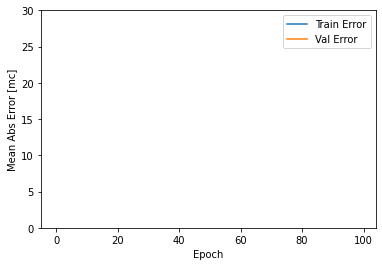

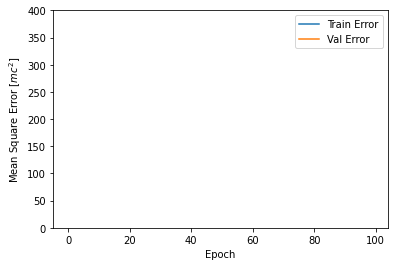

In [60]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [mc]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label = 'Val Error')
    plt.ylim([0,30])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$mc^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.ylim([0,400])
    plt.legend()
    plt.show()


plot_history(history)

1/1 [==============================] - 0s 48ms/step


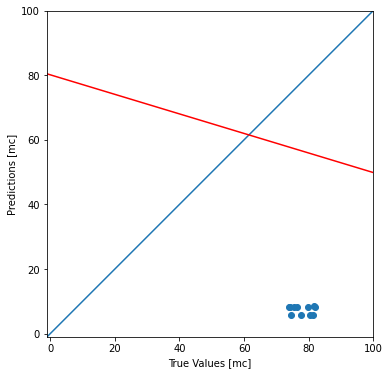

In [61]:
test_predictions = model.predict(x_test).flatten()
res = linregress(test_predictions, y_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [mc]')
plt.ylabel('Predictions [mc]')
plt.axis('equal')
plt.axis('square')
plt.xlim([-1,100])
plt.ylim([-1,100])
_ = plt.plot([-100, 100], [-100, 100])

plt.plot([-1, 100], res.intercept + res.slope*np.array([-1, 100]), 'r', label='fitted line')

In [62]:
# トレーニングした model をどこかで使用したいなら以下のようにモデルを保存する
model.save('saved_model/l1_1_model')

INFO:tensorflow:Assets written to: saved_model/l1_1_model/assets
